In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v)) # creating edge between child and node
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir':'LR'}) # left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular node for it
        dot.node(name = uid , label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node that is a oval one
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [40]:
class Value:
    def __init__(self, data, _children=(), _op = ' ', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None #empty function like a leaf node
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        output = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
        output._backward = _backward
        
        return output
        
    def __mul__(self, other):
        output = Value(self.data * other.data, (self, other),'*')
        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
        output._backward = _backward
        
        return output
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        output = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * output.grad
        output._backward = _backward
        
        return output
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [35]:
#inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

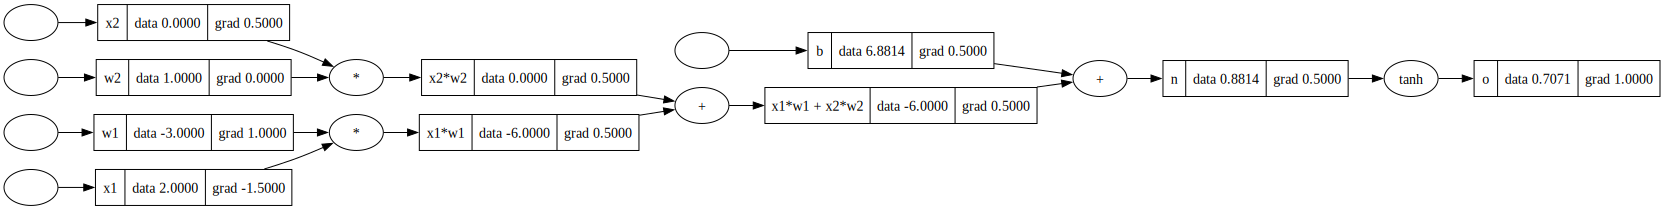

In [38]:
draw_dot(o)

In [ ]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [32]:
#implementing backward propagation without manually calling backward fn to each node
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [37]:
# after implementing backward fn in the value class. 
o.backward() 
# this function contains the topological sorting logic 

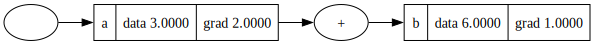

In [41]:
a = Value(3.0, label = 'a')
b = a+a;
b.label = 'b'
b.backward()
draw_dot(b)

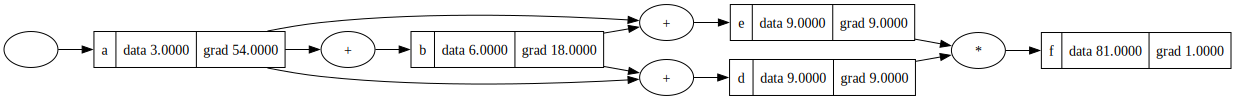

In [44]:
a = Value(3.0, label = 'a')
b = a+a; b.label = 'b'
d = a+b; d.label = 'd'
e = a+b; e.label = 'e'
f = d*e; f.label = 'f'

f.backward()
draw_dot(f)